In [6]:
#한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns
# 브라우저에서 바로 그려지도록 
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# EDA

In [4]:
train = pd.read_csv('/content/drive/MyDrive/DACON/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DACON/data/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/DACON/data/sample_submission.csv')

In [5]:
train.corr()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
본사정원수,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852
본사휴가자수,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894
본사출장자수,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164
본사시간외근무명령서승인건수,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168
현본사소속재택근무자수,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534
중식계,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287
석식계,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000


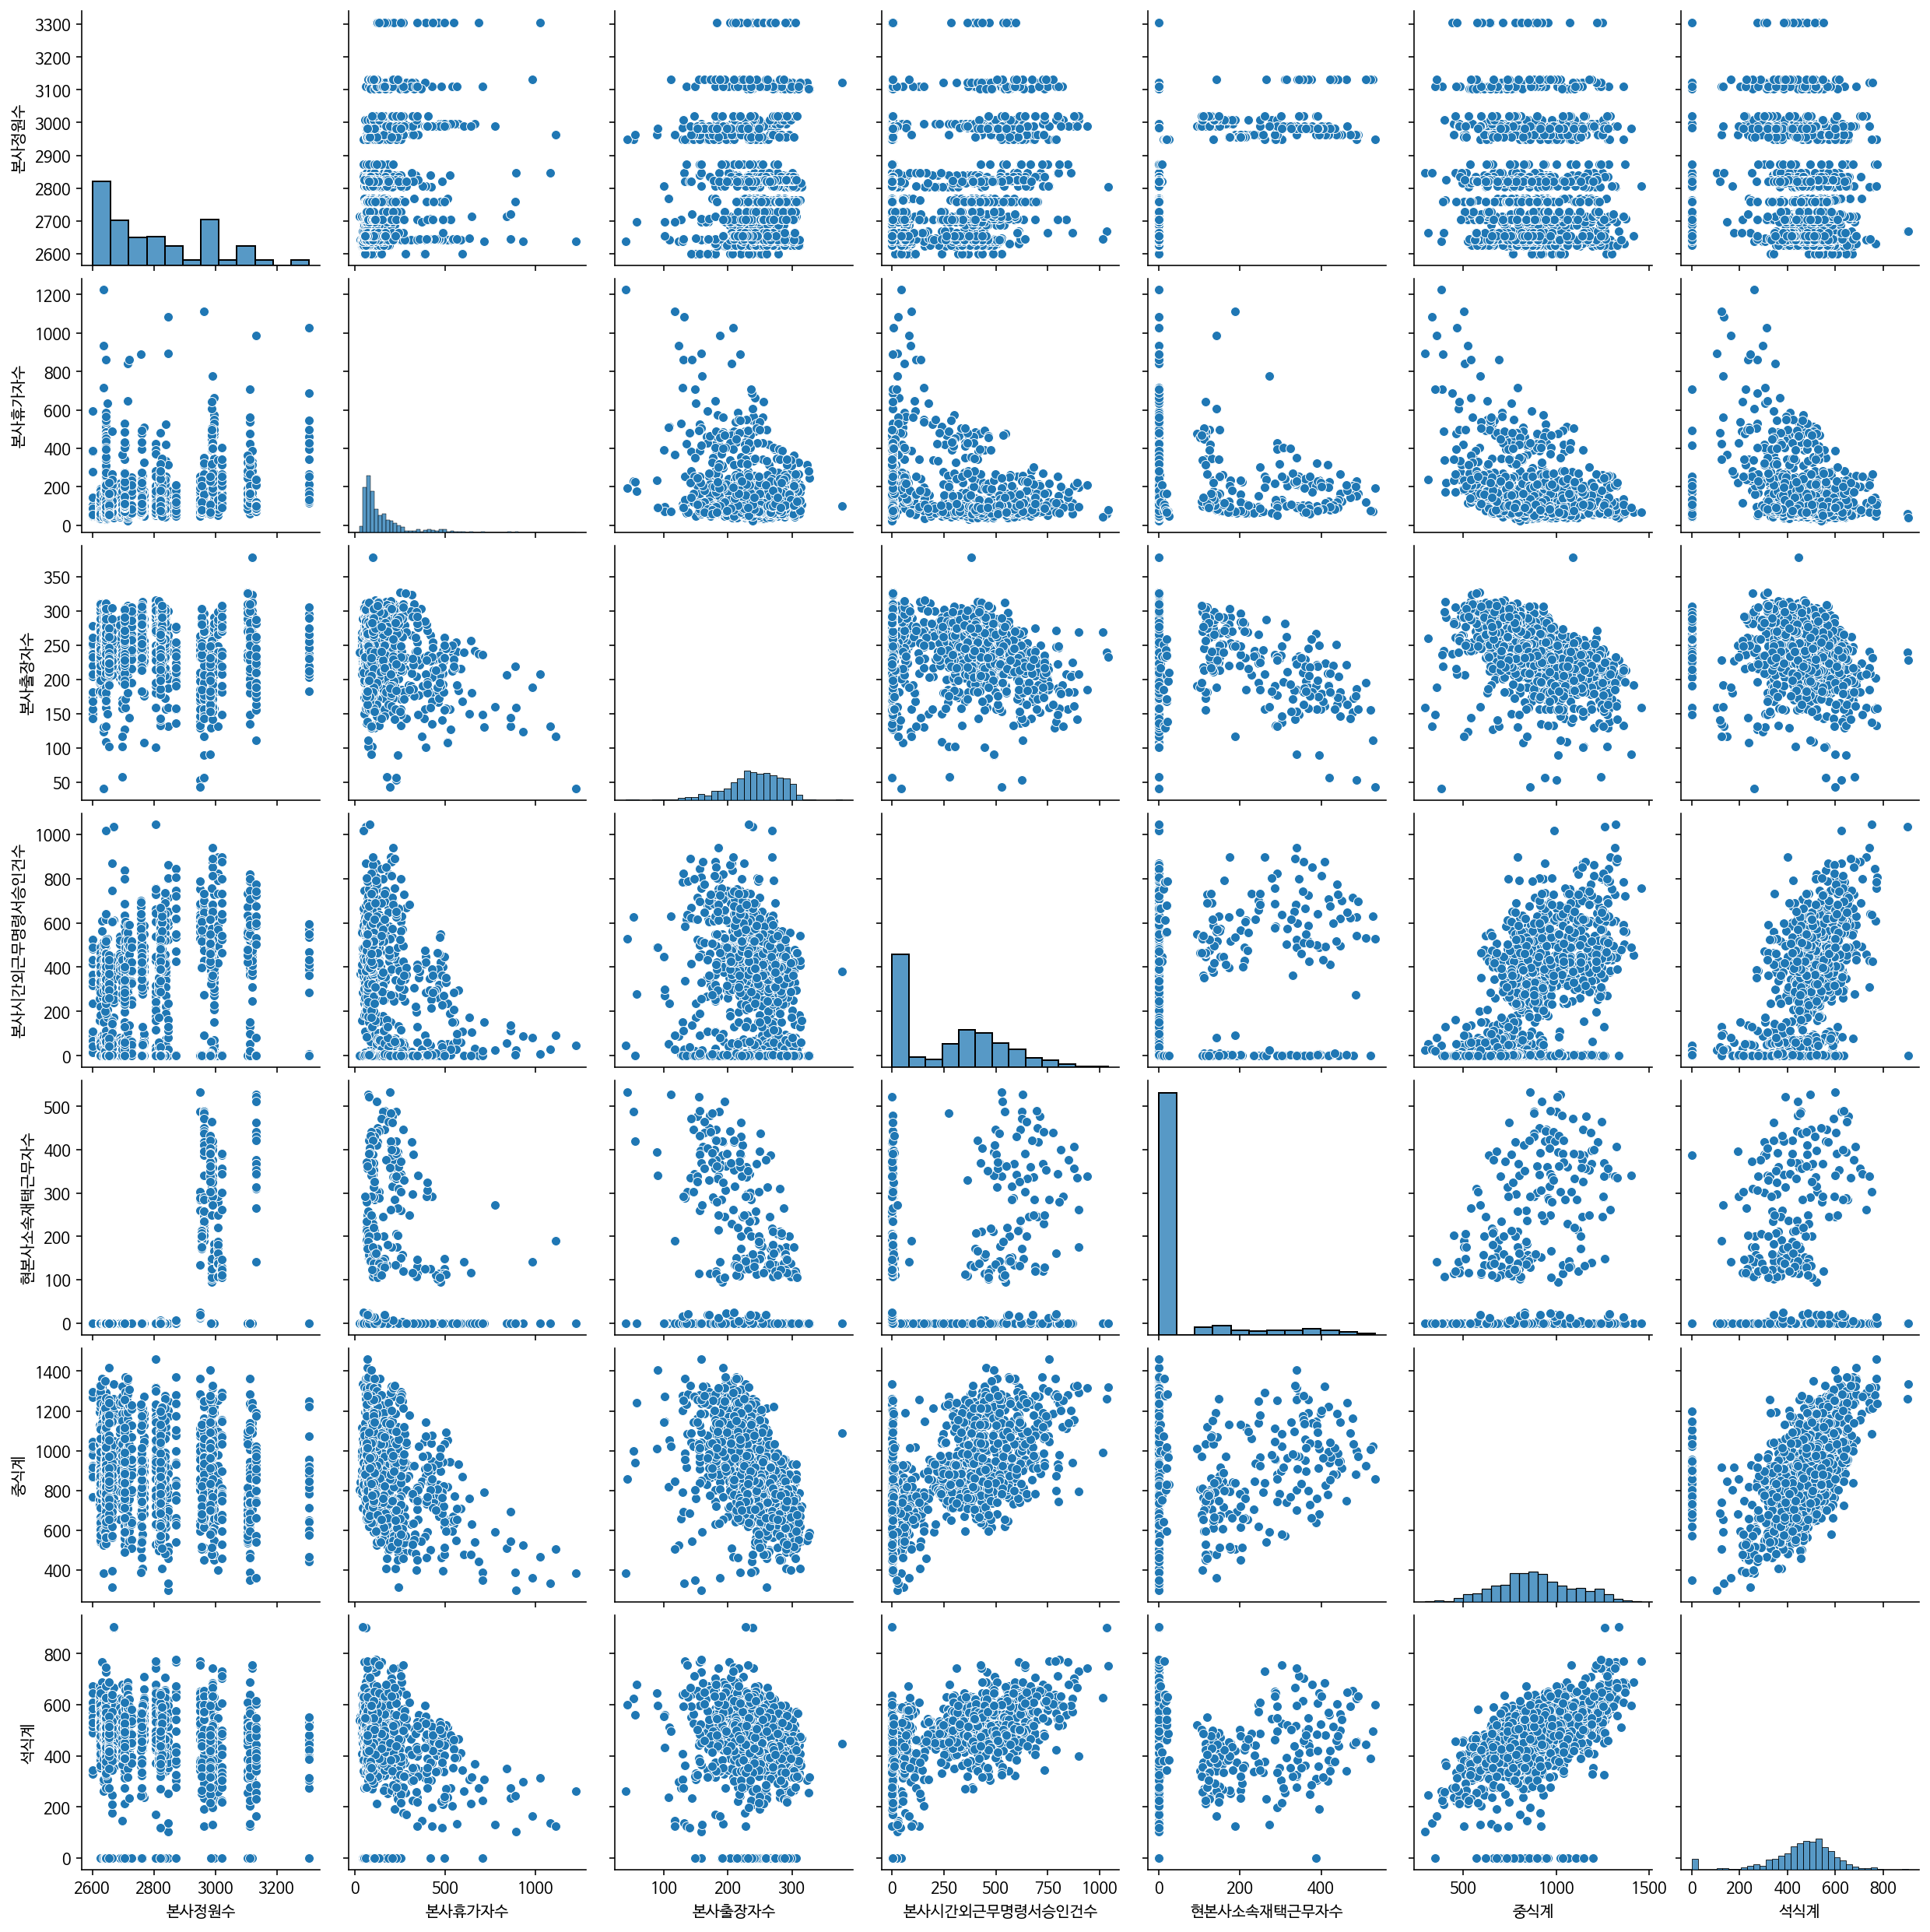

In [6]:
sns.pairplot(train)

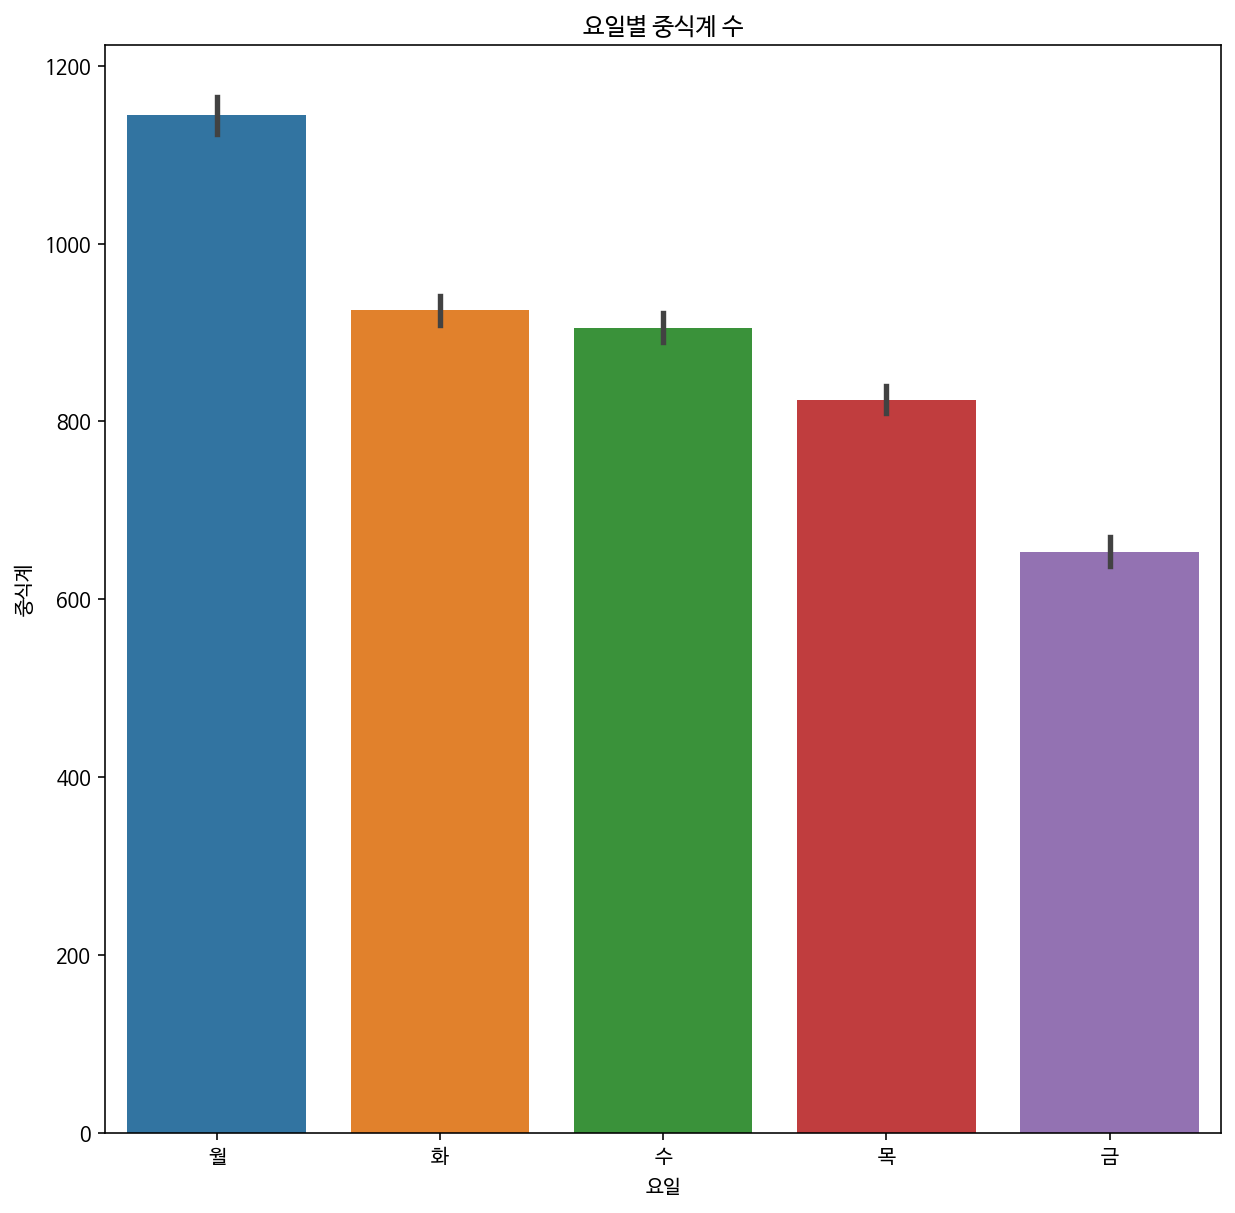

In [10]:
plt.figure(figsize=(10,10))

sns.barplot(x="요일", y="중식계", data=train)
plt.title("요일별 중식계 수")
plt.show()

#월요일이 가장 많고 금요일로 갈수록 줄어든다. 예상했던 그대로 나오는 것을 확인 가능

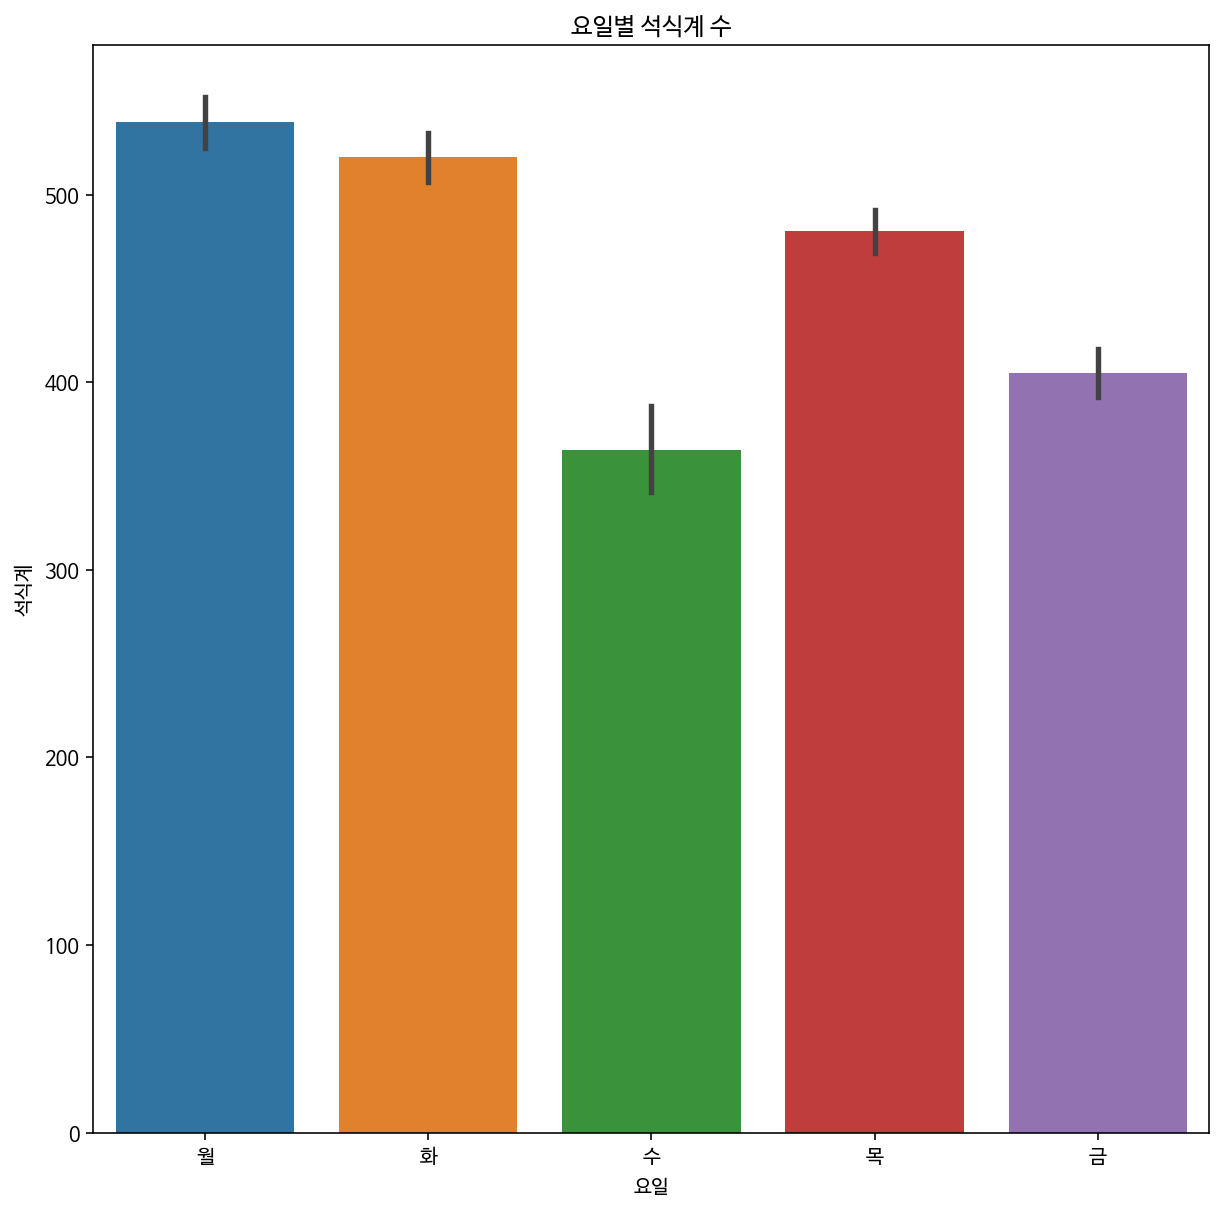

In [12]:
plt.figure(figsize=(10,10))


sns.barplot(x="요일", y="석식계", data=train)
plt.title("요일별 석식계 수")
plt.show()

#수요일 금요일이 가장 적은데
#그이유는 수요일날 한번 쉬는 의미에서 약속이 많을수 있다 생각.
#금요일 역시 약속이 있어서 나가서 먹을거라 생각
#=> 월,화,목 일 열심히 // 수,금은 좀 힘들어서 쉬는시간 필요하다 생각.

## target(중식계, 석식계)의 분포는 어떨까?

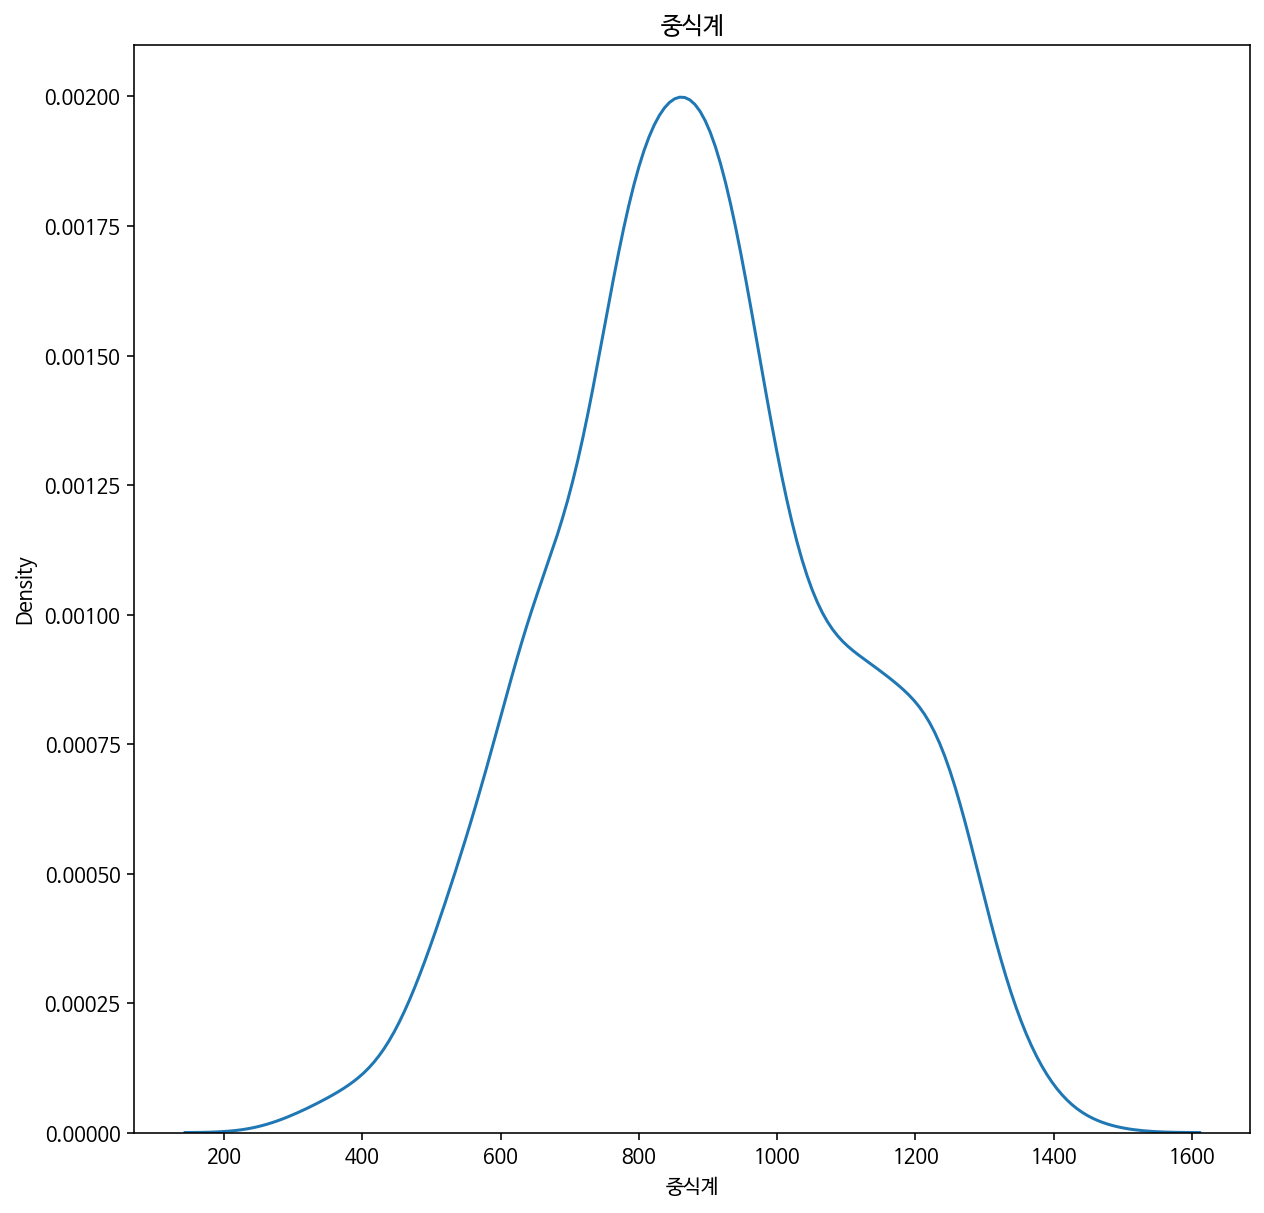

In [14]:
plt.figure(figsize=(10,10))
x = train['중식계']
sns.kdeplot(x)
plt.title("중식계")
plt.show()
# 정규분포를 띄므로, 정규화의 필요성은 업성 보인다.

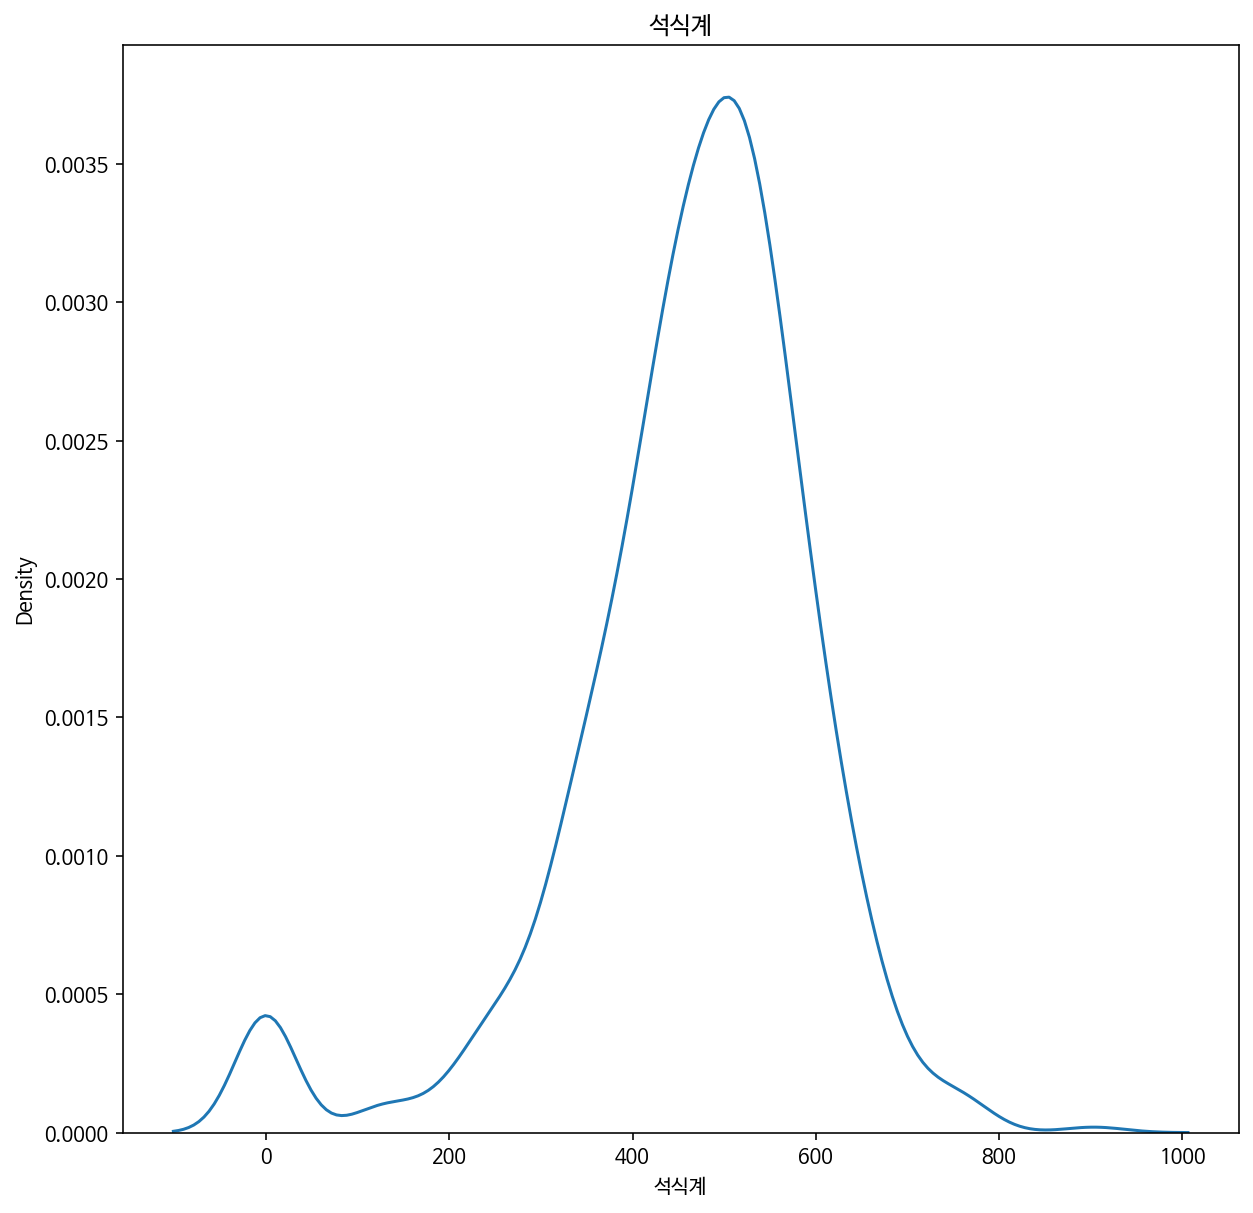

In [15]:
plt.figure(figsize=(10,10))
x = train['석식계']
sns.kdeplot(x)
plt.title("석식계")
plt.show()
#마찬가지로 정규분포를 어느 정도 만족하므로, 굳이 정규화의 필요성은 없어 보인다.

In [16]:
print(train['본사정원수'].max()) #총인원 3305
print('\n')
print(train['중식계'].describe()) #최대 1459
print('\n')
print(train['석식계'].describe()) #최대 905

3305


count    1205.000000
mean      890.334440
std       209.505057
min       296.000000
25%       758.000000
50%       879.000000
75%      1032.000000
max      1459.000000
Name: 중식계, dtype: float64


count    1205.000000
mean      461.772614
std       139.179202
min         0.000000
25%       406.000000
50%       483.000000
75%       545.000000
max       905.000000
Name: 석식계, dtype: float64


# Data preprocessing

In [17]:
train.columns = ['date','day','numbers','dayoff','work','outsidework','workfhome','break','lunch','dinner','lunch_t','dinner_t']
train.head(2) #제목이 오타도 날수있어서 영어로바꾸어주었다.

,date,day,numbers,dayoff,work,outsidework,workfhome,break,lunch,dinner,lunch_t,dinner_t
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [20]:
train['date'] = pd.to_datetime(train['date'])
train['yearmonth'] = train['date'].dt.strftime('%Y%m')

train['date'] = pd.to_datetime(train['date'])
train['date'] = train['date'].dt.strftime('%m%d')

train['Month'] = train['date'].str[0:2]
train['Date'] = train['date'].str[2:]
train.drop(['date','break'], inplace=True , axis=1) # 아침은 영향이 없을것같으므로 삭제

KeyError: ignored

In [21]:
train.head(2)

,day,numbers,dayoff,work,outsidework,workfhome,lunch,dinner,lunch_t,dinner_t,yearmonth,Month,Date
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,201602,02,01
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,201602,02,02


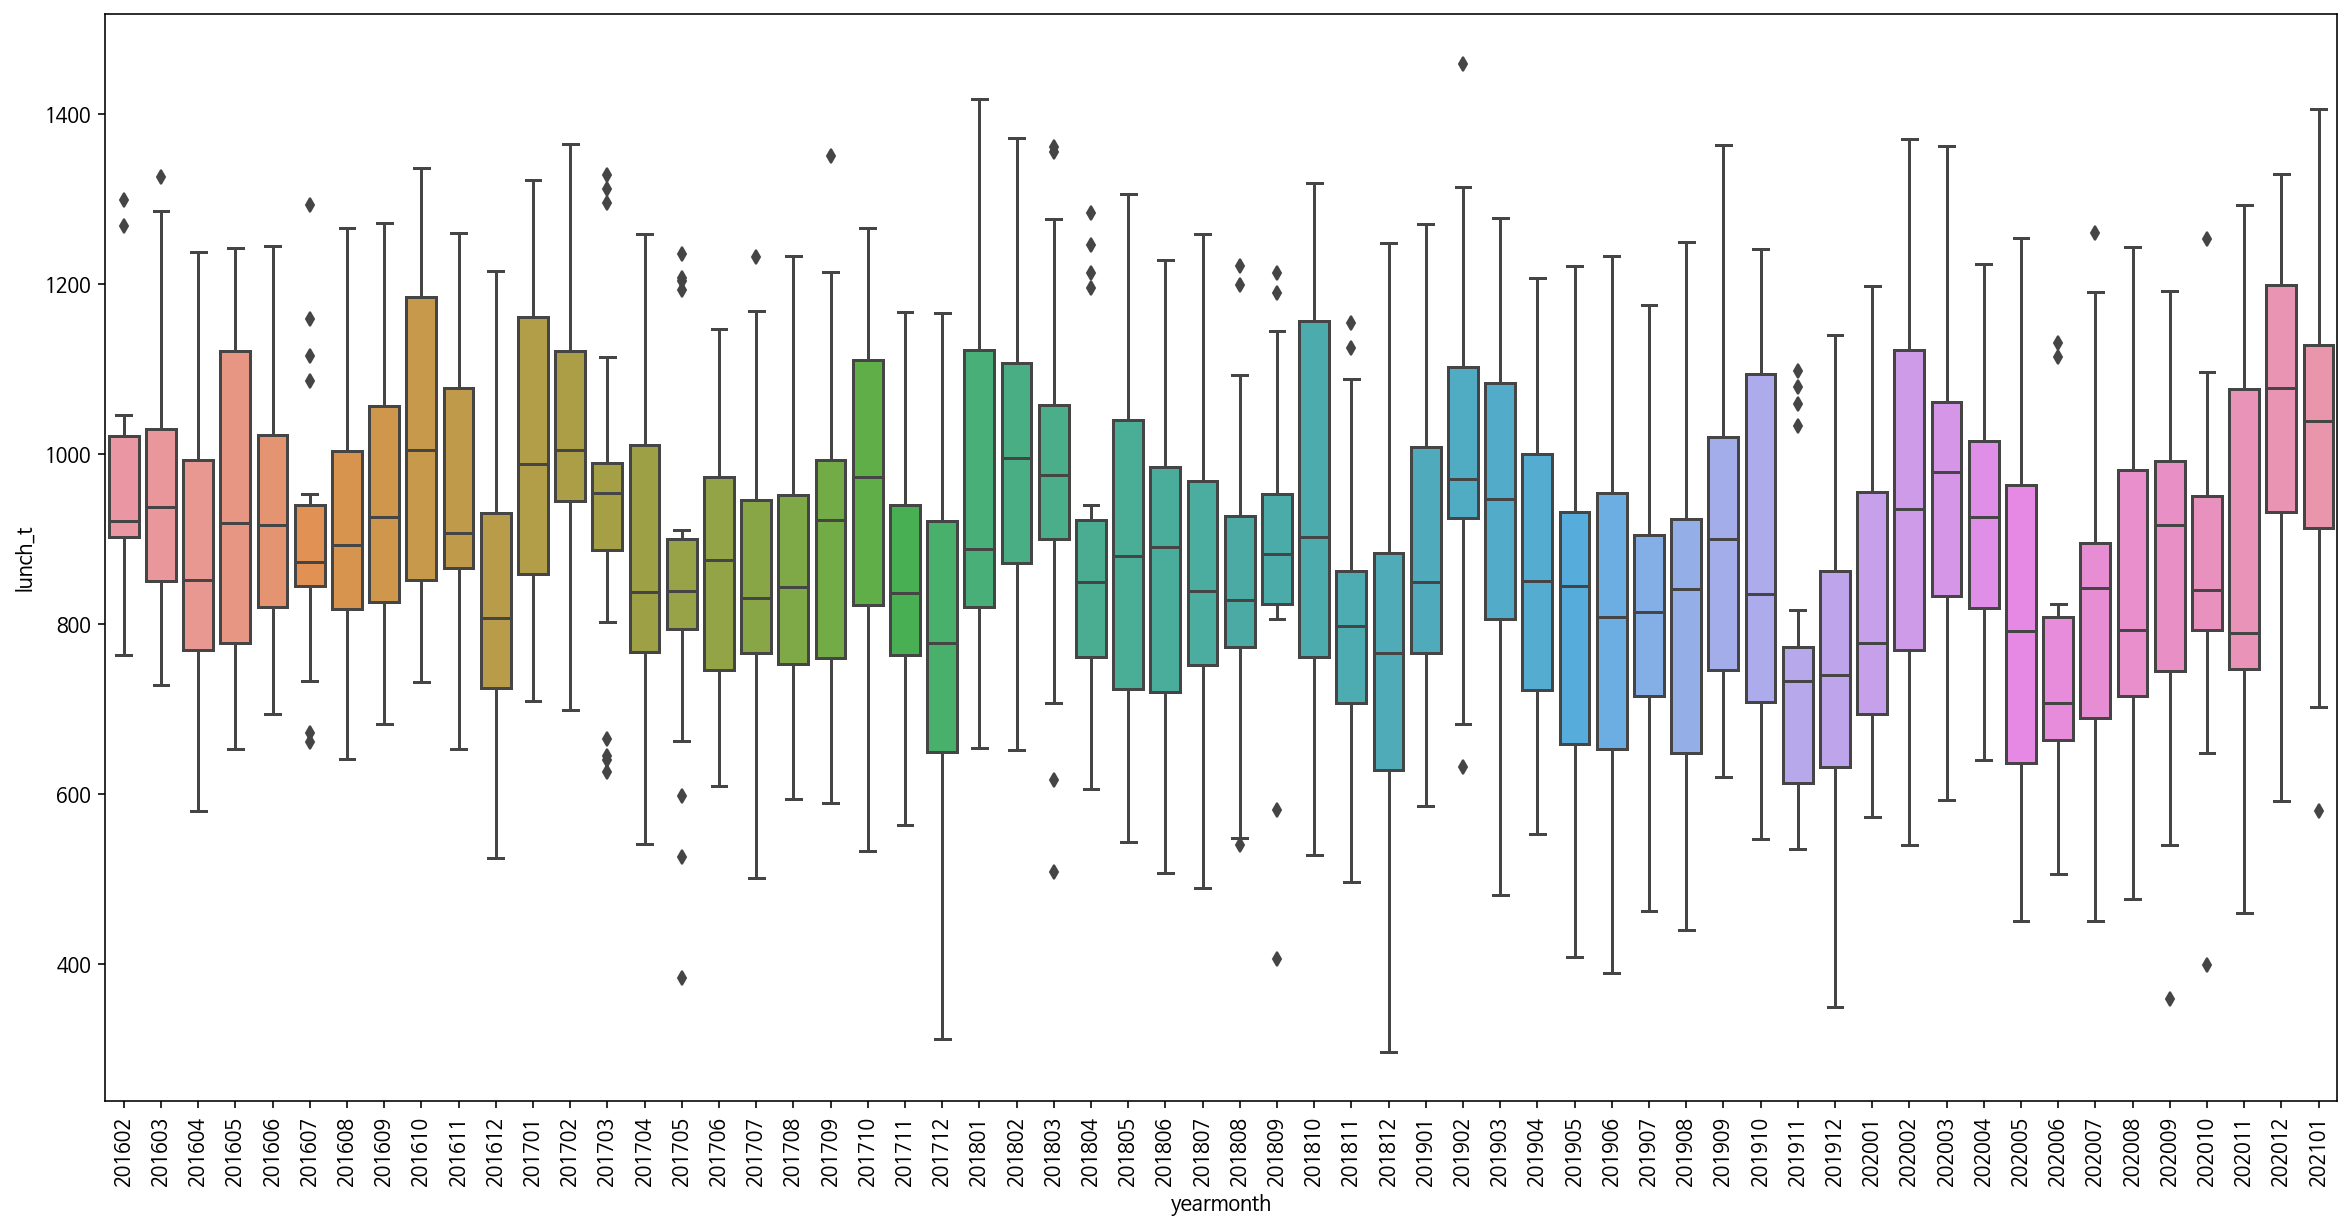

In [22]:
#월별 점심떄 사람수
plt.figure(figsize=(20,10))
rot = sns.boxplot(x='yearmonth',y='lunch_t', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)
#2017 년부 12월에 먹는 사람수가 좀 줄어든다.
#연말이라 회식이많은것같다. 그래서 밖에서 사먹고 와서 그런것같다.
#생각보다 코라나로인해 확 줄거나 그런것은 안보이는 것같다.

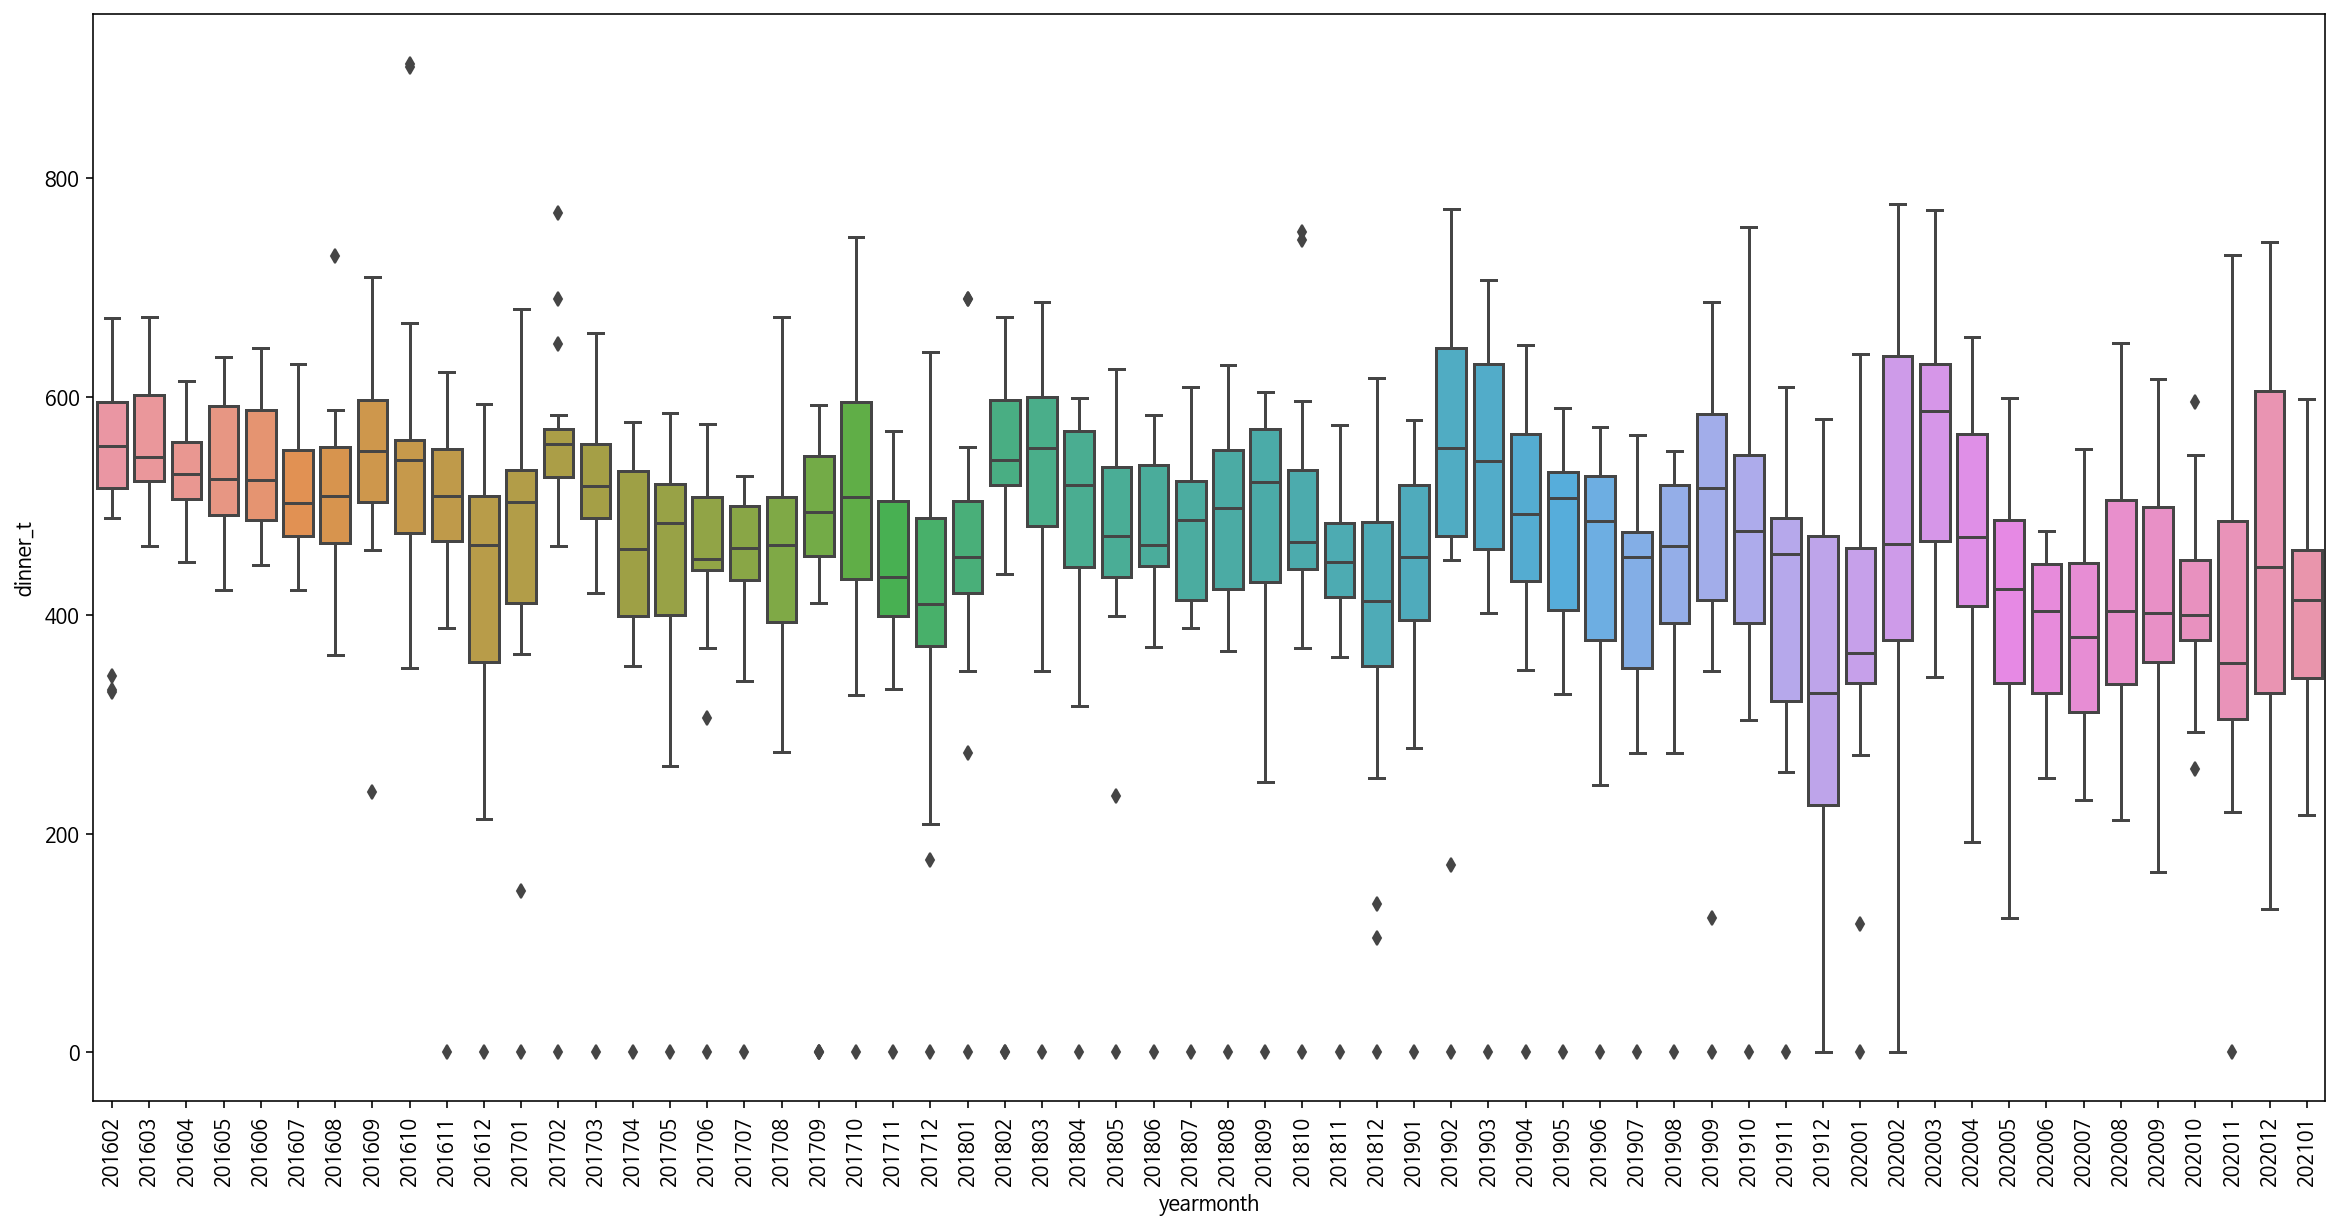

In [23]:
#월별 저녁
plt.figure(figsize=(20,10))
rot = sns.boxplot(x='yearmonth',y='dinner_t', data = train)

for item in rot.get_xticklabels():
    item.set_rotation(90)

#비슷한 양상을 석식계에서도 나타남을 확인 할 수 있다.

In [25]:
#중식계, 석식계 분서을 위한 yearmonth 변수 제거
train.drop('yearmonth', inplace=True , axis=1)

In [26]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch_menu = []

for day in range(len(train)):
    tmp = train.loc[day,'lunch'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch_menu.append(tmp) 
lunch_menu[5]

In [28]:
for bob in range(len(train)): # 밥은 큰 차이가 없을것같으므로 쌀밥은 다 밥으로 통일
    if '쌀밥' in lunch_menu[bob][0]:
        lunch_menu[bob][0] = '밥'
lunch_menu[3]

In [31]:
train['lunch_menu'] = lunch_menu
train.head(2)

,day,numbers,dayoff,work,outsidework,workfhome,lunch,dinner,lunch_t,dinner_t,Month,Date,lunch_menu
0,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,02,01,"[밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]"
1,화,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,02,02,"[밥, 김치찌개, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 요구르트, 배추겉절이]"


In [32]:
# 위에서 언급한 메인, 국, 반찬만 나누어주기

bob=[]
soup=[]
main=[]

for i in range(len(train)):
    if lunch_menu[i][0]:
        bob.append(lunch_menu[i][0])
    if lunch_menu[i][1]:
        soup.append(lunch_menu[i][1])
    if lunch_menu[i][2]:
        main.append(lunch_menu[i][2])

In [36]:
#누락이 있으면 안되므로 확인해주자

print(len(bob))
print(len(soup))
print(len(main))
print('----')
print(len(train))
#모두 동일한 개수대로 메뉴가 편성되어 split 됨을 확인할 수 있음.

1205
1205
1205
----
1205


In [37]:
#확인후에 추가
train['bob'] = bob
train['soup'] = soup
train['main'] = main

In [38]:
#그렇다면 밥의 분포는 어떻게 될지 궁금하지 않겠나?
train['bob'].value_counts()
#앞도적으로 밥의 분포가 높다 이를 제거하고 진행할지 판단 -> 우리의 목적은 중식,석식 인원 파악이다. 따라서 밥은 영향을 크게 주지 않읗것으로 판단.

밥              1003
콩나물밥             23
카레덮밥             18
나물비빔밥            15
곤드레밥*강된장         12
단호박영양밥           10
곤드레밥*양념장          8
김치제육덮밥            8
곤드레밥              8
비빔밥               8
카레라이스             8
짜장덮밥              6
낙지비빔밥             6
콩나물밥*양념장          5
산채비빔밥             5
마파두부덮밥            5
열무보리비빔밥           4
짜장밥               4
열무비빔밥             3
봄나물비빔밥            3
소불고기덮밥            3
단호박카레라이스          2
<초복특식>            2
곤드레밥*간장양념         2
콩나물밥*달래장          2
참치회덮밥             2
오곡밥               1
건강비빔밥*약고추장        1
새우날치알볶음밥          1
소고기콩나물밥*양념        1
닭살카레라이스           1
열무보리비빔밥/강된장       1
베이컨김치볶음밥          1
돈육버섯고추장덮밥         1
김밥볶음밥             1
비빔밥*약고추장          1
낙지비빔밥*계란후라이       1
계란채소볶음밥           1
전주비빔밥             1
호박된장국             1
고기듬뿍카레라이스         1
불고기비빔밥            1
버섯영양밥             1
김치필라프             1
파인애플볶음밥           1
김치볶음밥/계란          1
오므라이스             1
김치볶음밥             1
야채볶음밥*짜장소스        1
봄새싹비빔밥            1


In [39]:
train['soup'].value_counts()

맑은국          46
콩나물국         44
된장찌개         37
어묵국          31
배추된장국        28
             ..
올챙이만두국        1
들깨시락국         1
맑은순두부국        1
꽃게된장찌개        1
전주식콩나물해장국     1
Name: soup, Length: 272, dtype: int64

In [40]:
train['main'].value_counts()

오징어볶음        32
닭갈비          30
버섯불고기        29
훈제오리구이       27
돈육굴소스볶음      25
             ..
새우까스*탈탈소스     1
쇠고기모듬장조림      1
새우까스*칠리소스     1
메추리알조림        1
교촌간장치킨        1
Name: main, Length: 391, dtype: int64

In [43]:
#위와 같은 식으로 석식 메뉴 전처리 진행
dinner_menu = []
for day in range(len(train)):
    tmp = train.loc[day,'dinner'].split(' ')
    tmp = ' '.join(tmp).split()    

    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    dinner_menu.append(tmp) 

In [47]:
train['dinner_menu'] = dinner_menu
print(range(len(train)))
print(range(len(dinner_menu)))

range(0, 1205)
range(0, 1205)


In [48]:
bobd=[]
soupd=[]
maind=[]


for word in  dinner_menu:
    
    
    if len(word) == 0:
        bobd.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        soupd.append('None')
        maind.append('None')
    elif '*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '가정의달' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기계발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '*자기계발의날*' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')
    elif '자기개발의날' in word:
        bobd.append('None')
        soupd.append('None')
        maind.append('None')

    else:
        bobd.append(word[0])
        soupd.append(word[1])
        maind.append(word[2])

In [50]:
train['bobd'] = bobd
train['soupd'] = soupd
train['maind'] = maind

In [52]:
train['maind'].value_counts()[:10]
#특별하게 none이 41개나 분포되어 있음을 확인 가능하다.

None       41
닭갈비        16
떡볶이        16
돈육강정       15
돈육굴소스볶음    14
고추잡채*꽃빵    14
유린기        14
깐풍기        14
돈육장조림      14
주꾸미볶음      13
Name: maind, dtype: int64

In [54]:
train['soupd'].value_counts()[:10]

None     41
잔치국수     37
맑은국      33
된장찌개     30
육개장      29
가쯔오장국    29
미소장국     28
부대찌개     25
우동       23
닭개장      23
Name: soupd, dtype: int64

In [55]:
# Lunch Train 완성
#lunch_train
train = train[
    ['day','numbers','dayoff','work','outsidework','workfhome','lunch_t','Month','Date','bob','soup','main']
]

In [57]:
# encoding

train['day'] =  train['day'].astype('category')
train['day'] = train.day.cat.codes


train['bob'] =  train['bob'].astype('category')
train['bob'] = train.bob.cat.codes

train['soup'] =  train['soup'].astype('category')
train['soup'] = train.soup.cat.codes

train['main'] =  train['main'].astype('category')
train['main'] = train.main.cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [58]:
#현재 상주 인원 을 present라는 변수로 하여 지정한다.
train['present'] = train['numbers']-train['dayoff']-train['work']-train['outsidework']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
train.head(5)

,day,numbers,dayoff,work,outsidework,workfhome,lunch_t,Month,Date,bob,soup,main,present
0,3,2601,50,150,238,0.0,1039.0,02,01,22,189,236,2163
1,4,2601,50,173,319,0.0,867.0,02,02,22,28,8,2059
2,2,2601,56,180,111,0.0,1017.0,02,03,49,249,334,2254
3,1,2601,104,220,355,0.0,978.0,02,04,22,149,309,1922
4,0,2601,278,181,34,0.0,925.0,02,05,22,75,106,2108


In [68]:
train.corr()

,day,numbers,dayoff,work,outsidework,workfhome,lunch_t,bob,soup,main,present
day,1.000000,0.004999,-0.210219,-0.447183,0.539062,0.028364,0.584193,-0.051779,0.039582,0.033023,-0.327922
numbers,0.004999,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,0.008470,-0.047180,0.063892,0.409730
dayoff,-0.210219,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,0.008260,-0.033509,0.022062,-0.134040
work,-0.447183,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,0.062909,-0.016055,-0.038943,0.244995
outsidework,0.539062,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,-0.182796,0.078805,0.017750,-0.696646
workfhome,0.028364,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057818,-0.006933,0.029749,0.178831
lunch_t,0.584193,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,-0.041401,0.060575,0.041329,-0.290912
bob,-0.051779,0.008470,0.008260,0.062909,-0.182796,-0.057818,-0.041401,1.000000,-0.094330,-0.021443,0.169876
soup,0.039582,-0.047180,-0.033509,-0.016055,0.078805,-0.006933,0.060575,-0.094330,1.000000,0.030518,-0.087686
main,0.033023,0.063892,0.022062,-0.038943,0.017750,0.029749,0.041329,-0.021443,0.030518,1.000000,0.020313


In [ ]:
# 성능이 좋은 5개의 모델을 선정하여 blended하여 사용하였음.
best_5_l = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,76.2421,10521.6251,101.9336,0.7622,0.1262,0.0937,1.466
gbr,Gradient Boosting Regressor,78.8322,11351.9486,106.0020,0.7434,0.1321,0.0976,0.093
lightgbm,Light Gradient Boosting Machine,81.4987,11993.6786,108.6746,0.7278,0.1349,0.1000,0.125
rf,Random Forest Regressor,82.7813,12595.8678,111.4648,0.7154,0.1363,0.1011,0.544
et,Extra Trees Regressor,83.1840,12801.1093,112.4196,0.7103,0.1360,0.1011,0.461
xgboost,Extreme Gradient Boosting,83.9009,12930.8515,112.8829,0.7092,0.1383,0.1027,5.244
knn,K Neighbors Regressor,86.0518,13568.5398,115.6635,0.6917,0.1446,0.1067,0.065
huber,Huber Regressor,87.3062,15351.1686,122.9418,0.6618,0.1556,0.1131,0.035
par,Passive Aggressive Regressor,88.3216,15739.0736,124.4014,0.6547,0.1576,0.1148,0.017
br,Bayesian Ridge,90.2291,14537.9601,120.0484,0.6770,0.1517,0.1144,0.017


In [ ]:
https://dacon.io/competitions/official/235743/codeshare/2983?page=1&dtype=recent

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,71.3293,10045.5106,100.2273,0.8079,0.1335,0.0936
1,85.8228,12827.2612,113.2575,0.6599,0.1362,0.1006
2,71.1748,8476.5724,92.0683,0.8209,0.1117,0.0875
3,81.3017,12809.6309,113.1796,0.7444,0.1423,0.1015
4,80.0268,11230.6065,105.9746,0.7100,0.1264,0.0963
Mean,77.9311,11077.9163,104.9415,0.7486,0.1300,0.0959
SD,5.7838,1668.2451,8.0751,0.0602,0.0105,0.0051


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,76.7695,10914.4611,104.4723,0.7288,0.1287,0.0916


In [ ]:
submission['중식계'] = pred_esb_l['Label']

# 석식계 수요예측

In [ ]:
reg = setup(data= x2_train,
            target= '석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,383
1,Target,석식계
2,Original Data,"(1205, 6)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 9)"


In [ ]:
best_5_d = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,65.9662,10165.3439,100.2290,0.4541,1.0598,0.1271,1.507
gbr,Gradient Boosting Regressor,66.1119,9849.2360,98.7613,0.4699,1.0612,0.1293,0.159
rf,Random Forest Regressor,68.4585,10963.2935,104.0210,0.4120,1.0677,0.1328,0.556
et,Extra Trees Regressor,69.6187,11446.6780,106.3926,0.3851,1.0834,0.1344,0.461
huber,Huber Regressor,70.0103,11303.3559,105.7637,0.3909,1.0874,0.1411,0.027
par,Passive Aggressive Regressor,70.1658,11501.1237,106.6874,0.3803,1.0887,0.1420,0.022
lightgbm,Light Gradient Boosting Machine,70.2375,11053.8747,104.6049,0.4044,1.0668,0.1364,0.059
knn,K Neighbors Regressor,70.9706,11641.3179,107.2076,0.3709,1.0726,0.1433,0.064
br,Bayesian Ridge,72.1987,10870.2190,103.7152,0.4145,1.0696,0.1464,0.017
ridge,Ridge Regression,72.2125,10864.6502,103.6881,0.4148,1.0695,0.1460,0.018


In [ ]:
blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, x1_test)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,70.6898,10757.3103,103.7175,0.4437,1.1169,0.1504
1,55.7595,6893.4112,83.0266,0.5490,0.9183,0.1075
2,64.3928,10048.5023,100.2422,0.4633,1.1313,0.1296
3,67.3304,10721.5289,103.5448,0.4749,1.0387,0.1290
4,66.4141,10148.5238,100.7399,0.4573,1.1282,0.1142
Mean,64.9173,9713.8553,98.2542,0.4777,1.0667,0.1261
SD,5.0105,1439.4467,7.7440,0.0371,0.0816,0.0148


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,67.1846,11248.5527,106.0592,0.4652,1.2551,0.1344


In [ ]:
submission['석식계'] = pred_esb_d['Label']
submission

,일자,중식계,석식계
0,2021-01-27,1027.372041,366.467113
1,2021-01-28,956.073916,403.923754
2,2021-01-29,620.195387,285.419998
3,2021-02-01,1182.262427,493.408354
4,2021-02-02,965.536752,454.103761
5,2021-02-03,990.938059,401.174184
6,2021-02-04,930.737796,464.786192
7,2021-02-05,606.974622,325.236479
8,2021-02-08,1179.883725,616.394687
9,2021-02-09,982.957450,508.995501


In [ ]:
submission.to_csv('submission0310.csv', index = False)